In [ ]:
!pip install box2d-py
!pip install stable-baselines3
!pip install git+https://github.com/indrasweb/expert-offline-rl.git

In [4]:
import numpy as np
from google.colab import drive
import gym
from eorl import OfflineDataset
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch as T
import torch.nn as nn

from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.type_aliases import ReplayBufferSamples
from stable_baselines3.common.buffers import ReplayBuffer
from stable_baselines3 import SAC

In [5]:
DEVICE = T.device('cuda' if T.cuda.is_available() else 'cpu')
ENV_NAME = 'LunarLanderContinuous-v2'
DS_NAME = 'LunarLanderContinuous-v2'
SAVE_DIR = 'gdrive/MyDrive/SQIL/Imitation/'
ONLINE_STEPS = 5e5  # 500,000 online environment steps
EXPERT_STEPS = 1e5  # 100,000 expert steps
SEED = 1337

In [6]:
drive.mount('/content/gdrive/')  # model checkpoints + training stats 
set_random_seed(SEED)  # torch, np and py seeds
ds = OfflineDataset(ENV_NAME, dataset_size=EXPERT_STEPS)

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

Mounted at /content/gdrive/


In [7]:
env = Monitor(gym.make(ENV_NAME), filename=SAVE_DIR+ENV_NAME)

checkpoint_callback = CheckpointCallback(
    save_freq=ONLINE_STEPS, 
    save_path=SAVE_DIR, 
    name_prefix=ENV_NAME
)

model = SAC(
    env=env,
    policy='MlpPolicy',
    learning_starts=1000,
    batch_size=256,
    verbose=1
)

Using cuda device
Wrapping the env in a DummyVecEnv.


In [8]:
expert_buffer = ReplayBuffer(
    100000, 
    model.replay_buffer.observation_space, 
    model.replay_buffer.action_space, 
    DEVICE
)

def populate_expert_buffer(expert_buf, expert_ds, num_samples=20000):
    batch_size = 500
    batches = num_samples // batch_size
    
    for _ in range(batches):
        obs, acts, rwds, dones, next_obs = expert_ds.batch(batch_size)        
        for i in range(batch_size):
            expert_buf.add(obs[i], next_obs[i], acts[i], rwds[i], dones[i])

In [9]:
def modified_replay_buffer_sample(batch_size: int, env) -> ReplayBufferSamples:
    online_samples = super(model.replay_buffer.__class__, model.replay_buffer).sample(batch_size//2, env)
    expert_samples = expert_buffer.sample(batch_size//2, env)
    obs      = T.cat((online_samples.observations, expert_samples.observations))
    actions  = T.cat((online_samples.actions, expert_samples.actions))
    next_obs = T.cat((online_samples.next_observations, expert_samples.next_observations))
    rewards  = T.cat((T.zeros_like(online_samples.rewards), T.ones_like(expert_samples.rewards)))
    dones    = T.cat((online_samples.dones, expert_samples.dones))
    
    return ReplayBufferSamples(obs, actions, next_obs, dones, rewards)

model.replay_buffer.sample = modified_replay_buffer_sample

In [10]:
populate_expert_buffer(expert_buffer, ds, int(EXPERT_STEPS))

In [11]:
model.learn(ONLINE_STEPS, log_interval=10, callback=checkpoint_callback)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 104      |
|    ep_rew_mean     | -240     |
| time/              |          |
|    episodes        | 10       |
|    fps             | 607      |
|    time_elapsed    | 1        |
|    total timesteps | 1044     |
| train/             |          |
|    actor_loss      | -3.28    |
|    critic_loss     | 0.555    |
|    ent_coef        | 0.987    |
|    ent_coef_loss   | -0.0422  |
|    learning_rate   | 0.0003   |
|    n_updates       | 43       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 111      |
|    ep_rew_mean     | -236     |
| time/              |          |
|    episodes        | 20       |
|    fps             | 95       |
|    time_elapsed    | 23       |
|    total timesteps | 2211     |
| train/             |          |
|    actor_loss      | -9.74    |
|    critic_loss     | 0.508    |
|    ent_coef 

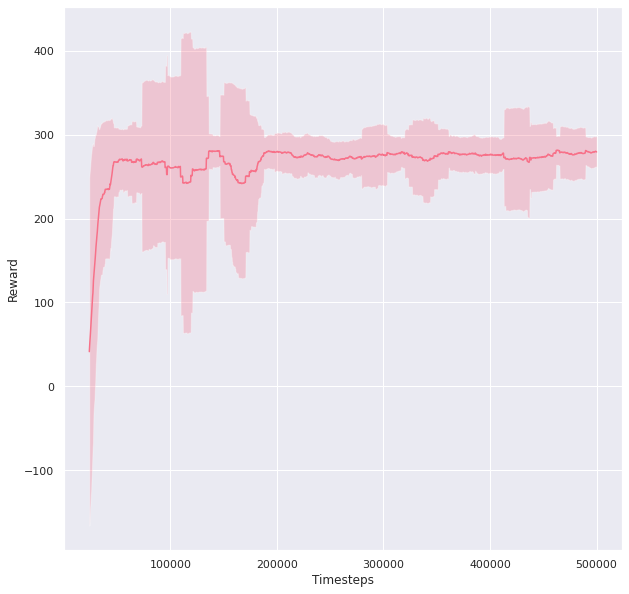

In [12]:
 def plot_log(df_path):

    with open(df_path, "rt") as f:
        _ = f.readline()
        df = pd.read_csv(f)
        df.sort_values("t", inplace=True)
        df.reset_index(inplace=True)

    # compute rolling avg and std
    sma_y = df['r'].rolling(100).mean()
    std_y = df['r'].rolling(100).std()
    
    # plot with seaborn
    sns.set()
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xlabel('Timesteps')
    ax.set_ylabel('Reward')
    clrs = sns.color_palette("husl", 8)

    true_x = (ONLINE_STEPS // max(df['index'])) * df['index']

    # fill standard deviation
    ax.plot(true_x, sma_y, c=clrs[0])
    ax.fill_between(true_x, sma_y-std_y,  sma_y+std_y, 
                    alpha=0.3, facecolor=clrs[0]) 
    plt.savefig(SAVE_DIR+ENV_NAME+'.reward_history.png', 
                dpi=300, pad_inches=0)
    plt.show()

plot_log(SAVE_DIR+ENV_NAME+'.monitor.csv')